# Undercomplete Autoencoder
    Developed by: Christian Eger
    Würzburg Institute for Systems Immunology, Faculty of Medicine, Julius-Maximilian-Universität Würzburg
    Created: 240327
    Latest version: 240328

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import anndata as ad
import helper
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import scanpy as sc

In [2]:
adata = ad.read_h5ad(
    '../data/Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad'
)
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [3]:
sc.pp.normalize_total(adata)

In [4]:
training_size, testing_size = helper.return_dataset_sizes(adata, 0.8, 0.01)

training_data, testing_data = helper.obs_to_tensor(adata, category=None, training_size=training_size, testing_size=testing_size)

training_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=64, shuffle=False)

In [6]:
min_val, max_val = helper.return_value_range(training_dataloader)
data_size = training_data.shape[1]
print(f'The range of values goes from {min_val} to {max_val}\n'
      f'The number of genes are {data_size}')

The range of values goes from 0 to 20328
The number of genes are 27208


In [7]:
class Undercomplete_Autoencoder(nn.Module):

    def __init__(self, data_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(data_size, 5000),
            nn.ReLU(),
            nn.Linear(5000, 200),
            nn.ReLU(),
            nn.Linear(200, 50)
        )
        self.decoder = nn.Sequential(
            nn.Linear(50, 200),
            nn.ReLU(),
            nn.Linear(200, 5000),
            nn.ReLU(),
            nn.Linear(5000, data_size)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print("Available CUDA devices:")
    for i in range(num_devices):
        print(f"  {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda:1") 
    print(f"Using CUDA device: {device}")
    torch.cuda.set_device(device)
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

Available CUDA devices:
  0: NVIDIA RTX 6000 Ada Generation
  1: NVIDIA RTX 6000 Ada Generation
Using CUDA device: cuda:1


In [10]:
model = Undercomplete_Autoencoder(data_size=data_size)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

In [15]:
num_epochs = 1000
training_losses = []
model.to(device)
for i in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for expression in training_dataloader:
        optimizer.zero_grad()
        expression = expression.to(device)
        output = model(expression)
        loss = loss_fn(output, expression)
        loss.backward()
        optimizer.step()
    training_losses.append(loss.item())

100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s]


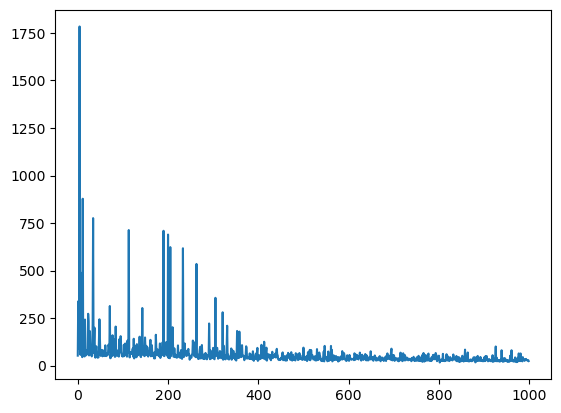

In [16]:
epochs = range(num_epochs)
plt.plot(epochs, training_losses)